In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.metrics import peak_signal_noise_ratio#to calculate PSNR
from skimage.metrics import structural_similarity as ssim#to calculate SSIM

Path = Path("/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation_laura/Flagship4ML/output_bright_for_error")

In [2]:
array1 = []
array2 = []
start = (120 - 96) // 2
end = start + 96

for ii in tqdm(range(20)):
    
    for band in np.arange(455, 855, 10):
        
        for exp in range(3):
            Path1 = Path / f"data_{ii}" / f"cutout_pau_nb{band}_exp{exp}.npy"
            Path2 = Path / f"data_{ii}" / f"clean_cutout_pau_nb{band}_exp{exp}.npy"
            
            data = np.load(Path1)
            data = data[:, start:end, start:end]
            
            data_clean = np.load(Path2)
            data_clean = data_clean[start:end, start:end]
            
            array1.append(data)
            array2.append(data_clean)
            
stamps_ori = np.stack(array1, axis=0)
stamps_cle = np.stack(array2, axis=0)

print(stamps_ori.shape)
print(stamps_cle.shape)

100%|██████████| 20/20 [02:54<00:00,  8.71s/it]


(2400, 30, 96, 96)
(2400, 96, 96)


In [3]:
import os
os.chdir('/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation/pn2v/src/pn2v')
from unet import UNet

from core import utils
from core import training
from core import histNoiseModel
import torch
from core import prediction
device=utils.getDevice()

path='/data/aai/scratch/jchan/denoise/PAUS/dinggetest/simulation_laura/Flagship4ML/output'
net=torch.load(path+"/best_conv_N2V_lauras_simnobkg.net")

CUDA available? True


/tmp/ipykernel_361/435163719.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net=torch.load(path+"/best_conv_N2V_lauras_simnobkg.net")


In [4]:
#generate mask file for the annulus
mask_for_annulus = np.zeros((stamps_cle.shape[1], stamps_cle.shape[2]),dtype=bool)

x_inner, y_inner = 20, 76
x_outer, y_outer = 10, 86

mask_for_annulus[x_outer:y_outer, x_outer:y_outer] = True
mask_for_annulus[x_inner:y_inner, x_inner:y_inner] = False

#generate mask file for the images
maskFWHM = np.zeros((stamps_cle.shape[0], stamps_cle.shape[1], stamps_cle.shape[2]),dtype=bool)

for i in tqdm(range(len(maskFWHM))):
    bkg_value = np.median(stamps_cle[i][mask_for_annulus])
    max_value = np.max(stamps_cle[i])
    maskFWHM[i] = stamps_cle[i] > ( bkg_value + (max_value - bkg_value) / 2 )

#generate area file for the images, actually is the number of the pixel in the simulation
area = np.zeros((len(stamps_cle)))

for i in tqdm(range(len(area))):
    area[i] = np.sum(maskFWHM[i])

100%|██████████| 2400/2400 [00:00<00:00, 124016.92it/s]


In [5]:
stamps_ori_nobgk = stamps_ori.copy()
stamps_cle_nobgk = stamps_cle.copy()

for i in tqdm(range(len(stamps_ori))):
    for j in range(len(stamps_ori[0])):
        value_bkg = np.median(stamps_cle[i])
        stamps_ori_nobgk[i][j] = stamps_ori[i][j] - value_bkg
    stamps_cle_nobgk[i] = stamps_cle[i] - value_bkg

100%|██████████| 2400/2400 [00:06<00:00, 390.30it/s]


In [6]:
n2vResult = np.zeros((10, stamps_cle.shape[1], stamps_cle.shape[2]))

for i in tqdm(range(10)):
    n2vResult[i] = prediction.tiledPredict(stamps_ori_nobgk[i][0], net ,ps=96, overlap=48,
                                                device=device, noiseModel=None)

100%|██████████| 10/10 [00:00<00:00, 31.91it/s]


In [7]:
ssim_value = np.zeros((10))
ssim_value_pn2v = np.zeros((10))
psnr_value = np.zeros((10))
psnr_value_pn2v = np.zeros((10))
std_value = np.zeros((10))
std_value_pn2v = np.zeros((10))

for num in tqdm(range(10)):
    max_signal_peak = np.max(stamps_cle_nobgk[num])
    
    ssim_value[num] = ssim(stamps_cle_nobgk[num], 
                      stamps_ori_nobgk[num][0], 
                      data_range=max_signal_peak)
    
    ssim_value_pn2v[num] = ssim(stamps_cle_nobgk[num], 
                      n2vResult[num], 
                      data_range=max_signal_peak)
    
    psnr_value[num] = peak_signal_noise_ratio(stamps_cle_nobgk[num], 
                                         stamps_ori_nobgk[num][0], 
                                         data_range=max_signal_peak)
    
    psnr_value_pn2v[num] = peak_signal_noise_ratio(stamps_cle_nobgk[num], 
                                         n2vResult[num], 
                                         data_range=max_signal_peak)

    std_value[num] = np.std(stamps_ori_nobgk[num][0][mask_for_annulus])
    std_value_pn2v[num] = np.std(n2vResult[num][mask_for_annulus])

100%|██████████| 10/10 [00:00<00:00, 642.80it/s]


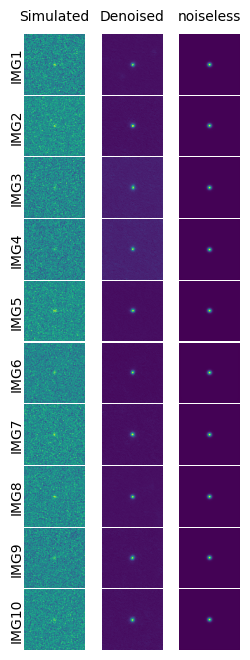

In [13]:
column_titles = ["Simulated", "Denoised", "noiseless"]
row_labels = ["IMG1", "IMG2", "IMG3", "IMG4", "IMG5", "IMG6", "IMG7", "IMG8", "IMG9", "IMG10"]

fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(3, 8))

for i in range(10):
    for j in range(3): 
        
        ax = axes[i, j]

        if j == 0:
            ax.imshow(stamps_ori_nobgk[i][0])
            ax.text(0, 0.5, row_labels[i], transform=ax.transAxes,
            fontsize=10, va='center', ha='right', rotation='vertical')
        elif j == 1:
            ax.imshow(n2vResult[i])
        elif j == 2:
            ax.imshow(stamps_cle_nobgk[i])
        
        ax.axis('off')
        
        if i == 0:
            ax.set_title(column_titles[j], fontsize=10, pad=10)

plt.subplots_adjust(wspace=0, hspace=0.02)
plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/IMG.pdf",
            format="pdf", bbox_inches="tight")
plt.show()

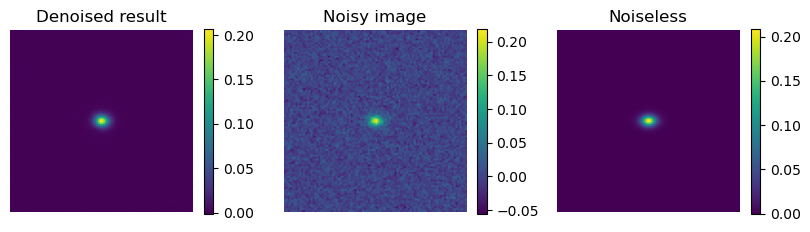

In [20]:
num = 410
num2 = 0
n2vResult = prediction.tiledPredict(stamps_ori_nobgk[num][num2], net ,ps=96, overlap=48,
                                            device=device, noiseModel=None)

fig, axes = plt.subplots(ncols=3,figsize=(10, 4))

im1 = axes[0].imshow(n2vResult)
axes[0].set_title('Denoised result')
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0],shrink = 0.6)

im2 = axes[1].imshow(stamps_ori_nobgk[num][num2])
axes[1].set_title('Noisy image')
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1],shrink = 0.6)

im3 = axes[2].imshow(stamps_cle_nobgk[num])
axes[2].set_title('Noiseless')
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2],shrink = 0.6)

plt.savefig("/data/aai/scratch/jchan/denoise/PAUS/output_save/brightdenoising.pdf",
            format="pdf", bbox_inches="tight")